In [1]:
!git config user.email "naazshafeer@gmail.com"
!git config user.name "Naaz Shafeer"

This is a separate notebook made to test the for loop made to see if my dynamical friction equation is coded correctly!

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

Intial Conditions

In [87]:
# region Code Snippet 1: This is the initial
G = const.G #change the innate time to years
m_gal = 1e21 * const.M_sun
#Masses
m1=1e7 * const.M_sun #mass of black hole A 
m2=1e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = G.value * (m1.value+m2.value)
#r_i
r1=[1e3,0,0] * u.pc
r2=[-1e3,0,0] * u.pc
#To arrays
r1=np.array(r1,dtype="float64") * u.pc
r2=np.array(r2,dtype="float64") * u.pc

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)
#V_i
v1=[0,0.25e3, 0] *u.km/u.s
v2=[0,-0.25e3,0] *u.km/u.s #km/s

# v1 = v1.to(u.m / u.year)
# v2 = v2.to(u.m / u.year)

#To arrays
v1=np.array(v1,dtype="float64") *u.km/u.s
v2=np.array(v2,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

r=np.linalg.norm(r2-r1)

a1 = (np.linalg.norm(r2 - r1) / 2)
o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
x = (a1 * o**(2)) / (G * m1)

ln_A = math.log10(x.to_value(u.dimensionless_unscaled))

F_D = 0.428 * ln_A * ((G * m1**(2))/r**(2))

v_r = v2 - v1

v_rmag = np.linalg.norm(v_r) 

v_rel_unit = (v_r / v_rmag)

F_D_i = (F_D * v_rel_unit[0])
F_D_j = (F_D * v_rel_unit[1])
F_D_k = (F_D * v_rel_unit[2])
    
F_D = np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])

    



F_D = F_D * ((u.kg * u.m)/(u.s**2))
    
T = 10 * u.Gyr # we can extract a from here - whole time in seconds
N = 5000
delta_t = T/ N

F_D1 = (F_D / m1).to(u.km / u.s**2)
F_D2 = (F_D / m2).to(u.km / u.s**2)

time_span=np.linspace(0, T, N) #Work on this with Kris' link

# endregion



~ So now we will implement those motion equations

In [88]:
r_com

<Quantity [-818.18181818,    0.        ,    0.        ] pc>

Gravitational potential is distance between two bodies and is also affected by dynamical friction which that one depends on the distance from the COM (as the bigger black hole has smaller r and thus bigger DF and smaller BH has bigger r and smaller DF)


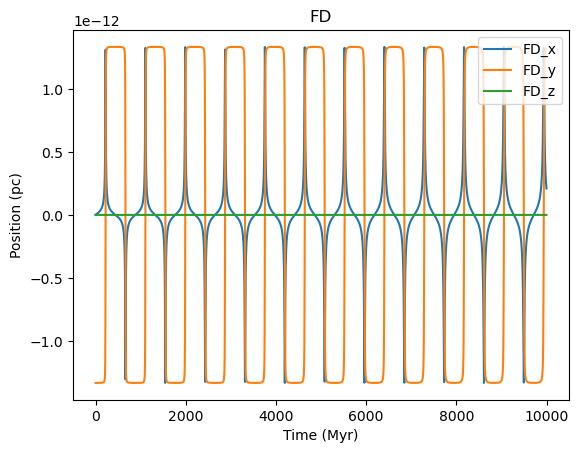

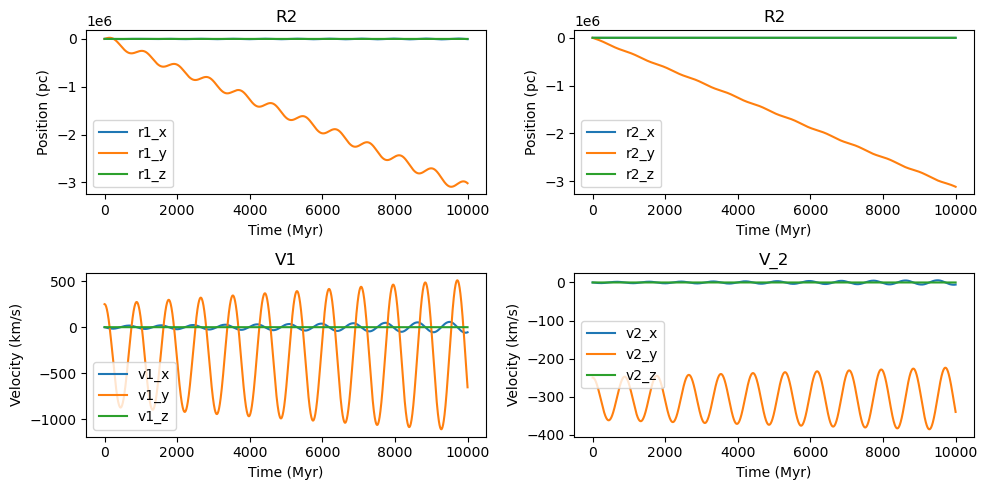

First four DF values:
[ 5.27757788e-16 -1.33334769e-12  0.00000000e+00]
[ 1.05554223e-15 -1.33334737e-12  0.00000000e+00]
[ 1.58356684e-15 -1.33334685e-12  0.00000000e+00]
[ 2.11204547e-15 -1.33334612e-12  0.00000000e+00]
[ 2.64119273e-15 -1.33334518e-12  0.00000000e+00]
[ 3.17122427e-15 -1.33334402e-12  0.00000000e+00]
[ 3.70235717e-15 -1.33334265e-12  0.00000000e+00]
[ 4.23481030e-15 -1.33334107e-12  0.00000000e+00]
[ 4.76880466e-15 -1.33333926e-12  0.00000000e+00]
[ 5.30456375e-15 -1.33333724e-12  0.00000000e+00]
[ 5.84231398e-15 -1.33333499e-12  0.00000000e+00]
[ 6.38228505e-15 -1.33333252e-12  0.00000000e+00]
[ 6.92471033e-15 -1.33332981e-12  0.00000000e+00]
[ 7.46982730e-15 -1.33332687e-12  0.00000000e+00]
[ 8.01787794e-15 -1.33332368e-12  0.00000000e+00]
[ 8.56910925e-15 -1.33332026e-12  0.00000000e+00]
[ 9.12377363e-15 -1.33331658e-12  0.00000000e+00]
[ 9.68212943e-15 -1.33331264e-12  0.00000000e+00]
[ 1.02444414e-14 -1.33330844e-12  0.00000000e+00]
[ 1.08109813e-14 -1.33330396

In [89]:
first_four_r1 = []
first_four_r2 = []
first_four_v1 = []
first_four_v2 = []
first_four_F_D = []

for i in range(N):
    dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) - F_D1
    dv2bydt=((G*m1*(r2-r1))/r**3).to(u.km / u.s**2) - F_D2
    v1 += dv1bydt * delta_t
    v2 += dv2bydt * delta_t

    r1 += v1.to(u.pc / u.s) * delta_t
    r2 += v2.to(u.pc / u.s) * delta_t
    #rcom - r1_sol that should be the one used for r**2 as we are looking at it as two bodies interacting with the COM
    F_D = 0.428 * ln_A * ((G * m1**2) / r**2)


    v_r = v2 - v1
    v_rmag = np.linalg.norm(v_r)  # Magnitude of relative velocity
    v_rel_unit = v_r / v_rmag  # Unit vector of relative velocity


    F_D_i = F_D * v_rel_unit[0]
    F_D_j = F_D * v_rel_unit[1]
    F_D_k = F_D * v_rel_unit[2]

    F_D = np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])

    F_D = F_D * ((u.kg * u.m)/(u.s**2))
    
    F_D1 = (F_D / m1).to(u.km / u.s**2)
    F_D2 = (F_D / m2).to(u.km / u.s**2)


    first_four_F_D.append([

        (F_D_i.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D_j.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D_k.to((u.kg * u.m) / (u.s**2))/m1).value
    ])

    first_four_r1.append(r1.copy())
    first_four_r2.append(r2.copy())
    first_four_v1.append(v1.copy())
    first_four_v2.append(v2.copy())


time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit


first_four_r1 = np.array(first_four_r1)  
first_four_r2 = np.array(first_four_r2)  
first_four_v1 = np.array(first_four_v1)  
first_four_v2 = np.array(first_four_v2) 
first_four_F_D = np.array(first_four_F_D) 


# region
plt.plot(time_values, first_four_F_D[:, 0], label="FD_x")
plt.plot(time_values, first_four_F_D[:, 1], label="FD_y")
plt.plot(time_values, first_four_F_D[:, 2], label="FD_z")
plt.title("FD")
plt.xlabel("Time (Myr)")
plt.ylabel("Position (pc)")
plt.legend()

fig, axs = plt.subplots(2, 2, figsize=(10, 5))


axs[0, 0].plot(time_values, first_four_r1[:, 0], label="r1_x")
axs[0, 0].plot(time_values, first_four_r1[:, 1], label="r1_y")
axs[0, 0].plot(time_values, first_four_r1[:, 2], label="r1_z")
axs[0, 0].set_title("R2")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()


axs[0, 1].plot(time_values, first_four_r2[:, 0], label="r2_x")
axs[0, 1].plot(time_values, first_four_r2[:, 1], label="r2_y")
axs[0, 1].plot(time_values, first_four_r2[:, 2], label="r2_z")
axs[0, 1].set_title("R2")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


axs[1, 0].plot(time_values, first_four_v1[:, 0], label="v1_x")
axs[1, 0].plot(time_values, first_four_v1[:, 1], label="v1_y")
axs[1, 0].plot(time_values, first_four_v1[:, 2], label="v1_z")
axs[1, 0].set_title("V1")
axs[1, 0].set_xlabel("Time (Myr)")
axs[1, 0].set_ylabel("Velocity (km/s)")
axs[1, 0].legend()


axs[1, 1].plot(time_values, first_four_v2[:, 0], label="v2_x")
axs[1, 1].plot(time_values, first_four_v2[:, 1], label="v2_y")
axs[1, 1].plot(time_values, first_four_v2[:, 2], label="v2_z")
axs[1, 1].set_title("V_2")
axs[1, 1].set_xlabel("Time (Myr)")
axs[1, 1].set_ylabel("Velocity (km/s)")
axs[1, 1].legend()
# endregion

plt.tight_layout()
plt.show()

print("First four DF values:")
for val in first_four_F_D:
    print(val)

In [90]:
(m1*first_four_r1+m2*first_four_r2)/(m1+m2)

<Quantity [[-8.18263609e+02, -4.18350953e+02,  0.00000000e+00],
           [-8.18427187e+02, -8.36712439e+02,  0.00000000e+00],
           [-8.18672531e+02, -1.25512629e+03,  0.00000000e+00],
           ...,
           [-1.86547666e+03, -3.10406064e+06,  0.00000000e+00],
           [-1.88615136e+03, -3.10481083e+06,  0.00000000e+00],
           [-1.90669675e+03, -3.10556501e+06,  0.00000000e+00]]>

In [91]:
r_com=(m1*first_four_r1+m2*first_four_r2)/(m1+m2)
r_com_mag = np.sqrt(r_com[:,0]**2 + r_com[:,1]**2 + r_com[:,2]**2)

r_com_mag

<Quantity [9.19006449e+02, 1.17043187e+03, 1.49852151e+03, ...,
           3.10406120e+06, 3.10481141e+06, 3.10556560e+06]>

In [92]:
rmax = first_four_r1 - r_com


In [93]:
r_com=(m1*first_four_v1+m2*first_four_v2)/(m1+m2)

print(r_com)

[[-3.99872765e-02 -2.04530154e+02  0.00000000e+00]
 [-7.99725145e-02 -2.04535304e+02  0.00000000e+00]
 [-1.19947620e-01 -2.04560904e+02  0.00000000e+00]
 ...
 [-1.01688523e+01 -3.64809216e+02  0.00000000e+00]
 [-1.01077783e+01 -3.66768356e+02  0.00000000e+00]
 [-1.00445631e+01 -3.68715121e+02  0.00000000e+00]]


In [94]:
r_com

<Quantity [[-3.99872765e-02, -2.04530154e+02,  0.00000000e+00],
           [-7.99725145e-02, -2.04535304e+02,  0.00000000e+00],
           [-1.19947620e-01, -2.04560904e+02,  0.00000000e+00],
           ...,
           [-1.01688523e+01, -3.64809216e+02,  0.00000000e+00],
           [-1.01077783e+01, -3.66768356e+02,  0.00000000e+00],
           [-1.00445631e+01, -3.68715121e+02,  0.00000000e+00]]>

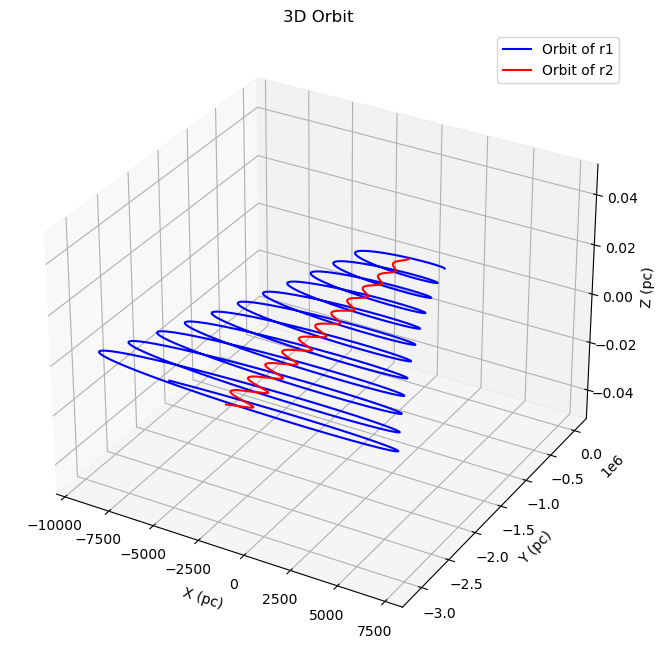

In [95]:
from mpl_toolkits.mplot3d import Axes3D  


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot(first_four_r1[:, 0], first_four_r1[:, 1], first_four_r1[:, 2], label="Orbit of r1", color="blue")


ax.plot(first_four_r2[:, 0], first_four_r2[:, 1], first_four_r2[:, 2], label="Orbit of r2", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit')


ax.legend()


plt.show()